# Imports

In [13]:
import sys, os
is_conda = os.path.exists(os.path.join(sys.prefix, 'conda-meta'))

if not is_conda:
    import findspark 
    findspark.init()

from pyspark.sql import SparkSession
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.functions import col, datediff, unix_timestamp
import csv
from IPython.core.display import display, HTML
from collections import defaultdict

# Para una lectura más distendida de la memoria
MODO_JAJAS = False

Matplotlib is building the font cache; this may take a moment.


# Lectura de datos

In [2]:
spark = SparkSession.builder.appName("taxis").master("local[*]").getOrCreate()
df = spark.read.csv('./tripdata_2017_01.csv', header=True, inferSchema=True)

In [3]:
df.printSchema()
dfP=df.toPandas()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



# Limpieza de datos

In [4]:
display(dfP)
display(dfP.describe().T)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,12.5,0.0,0.5,2.00,0.00,0.3,15.30
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,5.0,0.0,0.5,1.45,0.00,0.3,7.25
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,5.5,0.0,0.5,1.00,0.00,0.3,7.30
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,6.0,0.0,0.5,1.70,0.00,0.3,8.50
4,2,2017-01-01 00:00:00,2017-01-01 00:00:00,1,0.02,2,N,249,234,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971005,2,2017-01-17 13:16:22,2017-01-17 13:35:14,1,3.43,1,N,264,264,2,14.5,0.0,0.5,0.00,0.00,0.3,15.30
971006,2,2017-01-17 13:16:23,2017-01-17 13:23:01,1,0.78,1,N,161,237,1,6.0,0.0,0.5,1.36,0.00,0.3,8.16
971007,2,2017-01-17 13:16:23,2017-01-17 13:23:51,1,0.95,1,N,237,229,2,6.5,0.0,0.5,0.00,0.00,0.3,7.30
971008,2,2017-01-17 13:16:23,2017-01-17 13:32:45,1,1.68,1,N,170,48,1,11.5,0.0,0.5,2.46,0.00,0.3,14.76


,count,mean,std,min,25%,50%,75%,max
VendorID,971010.0,1.556951,0.496746,1.00,1.00,2.00,2.00,2.00
passenger_count,971010.0,1.685989,1.291705,0.00,1.00,1.00,2.00,9.00
trip_distance,971010.0,3.031285,3.785847,0.00,1.00,1.70,3.25,151.70
RatecodeID,971010.0,1.044729,0.461631,1.00,1.00,1.00,1.00,99.00
PULocationID,971010.0,160.378031,67.938198,1.00,113.00,161.00,231.00,265.00
DOLocationID,971010.0,158.556712,72.276821,1.00,100.00,161.00,233.00,265.00
payment_type,971010.0,1.371974,0.503326,1.00,1.00,1.00,2.00,4.00
fare_amount,971010.0,13.108188,546.736933,-120.00,6.50,9.00,14.00,538579.20
extra,971010.0,0.209993,0.261634,-1.00,0.00,0.00,0.50,55.54
mta_tax,971010.0,0.497214,0.040586,-0.50,0.50,0.50,0.50,0.50


### Elementos extraños en el dataset

Lista de comportamientos extraños en los datos, y por tanto, inválidos a la hora de utilizar datos que deberían ser coherentes basándonos en la información de cada campo proporcionada por la [documentación](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

* Existen carreras en las que la distancia es 0
* Existen propinas negativas
* "extra" con valores diferentes a 0 (ya que puede no haber extras), 0.5 y 1
* Existen viajes con un precio final negativo
* "MTA_tax" debe valer siempre 0.50. Valores diferentes son erróneos, y por tanto puede que el resto de la información también
    * De forma similar, "Improvement_surcharge" no debe valer menos de 0.30
* Carreras cuya fecha de fin sea igual o anterior a la fecha de inicio
* Existen tarifas con valores negativos. No tiene sentido ya que la tarifa va en función del tiempo y la distancia recorridas
* "Improvement_surcharge" es un valor en desuso, por lo que debería valer en el menor caso 0, no -0.3

### Elementos extraños PERO posibles

* Número de pasajeros es 0. Dado que es un valor que introduce el propio conductor, muy probablemente le de bastante igual introducir bien el valor.
* Un viaje empieza y acaba en la misma zona.



### Limpieza realizada

A partir de los comportamientos observados se ha procedido a eliminar las carreras que cumplen las siguientes condiciones:

- Campo "tip_amount" con valores menor a 0
- Campo "total_amount" con valores menor o igual a 0
- Campo "trip_distance" con valores menor o igual a 0
- Campo "fare_amount" con valores menor o igual a 0
- Campo "extra" con valores diferentes de 0, 0.5 y 1
- Campo "MTA_tax" con valor distinto de 0.5
- Campo "Improvement_surcharge" con valor distinto de 0 o 0.3
- Campo "tpep_dropoff_datetime" es anterior o igual a "tpep_pickup_datetime"

In [5]:
# Convertimos las fechas a timestamp, para que dejen de ser strings a secas
# y guardamos su diferencia para luego tener más fácil el filtrado y otros cálculos

# ----------------------------------------------------------------------------------
# ESTO ES ABSURDAMENTE LENTO, TIENE QUE HABER ALGUNA FORMA MÁS FÁCIL DE HACER ESTO
# ----------------------------------------------------------------------------------
df = df.withColumn(
    "tpep_pickup_timestamp", unix_timestamp(col("tpep_pickup_datetime").cast("timestamp"))
).withColumn(
    "tpep_dropoff_timestamp", unix_timestamp(col("tpep_dropoff_datetime").cast("timestamp"))
).withColumn(
    "time_diff", col("tpep_dropoff_timestamp") - col("tpep_pickup_timestamp")  # Segundos
)

df.createOrReplaceTempView('datosCarreras')
# display(df.toPandas())

In [6]:
datosLimpios = spark.sql("""
    SELECT * FROM datosCarreras WHERE
        tip_amount >= 0 AND
        total_amount > 0 AND
        trip_distance > 0 AND
        fare_amount > 0 AND
        (extra == 0 OR extra == 0.5 OR extra == 1) AND
        mta_tax == 0.5 AND
        improvement_surcharge >= 0 AND
        time_diff > 0
""")
print(datosLimpios.count())
datosLimpios.createOrReplaceTempView('datosCarrerasLimpios')
datosLimpiosP = datosLimpios.toPandas()

961150


In [7]:
display(datosLimpiosP)
display(datosLimpiosP.describe().T)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tpep_pickup_timestamp,tpep_dropoff_timestamp,time_diff
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,12.5,0.0,0.5,2.00,0.00,0.3,15.30,1483956808,1483957545,737
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,5.0,0.0,0.5,1.45,0.00,0.3,7.25,1483957947,1483958161,214
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,5.5,0.0,0.5,1.00,0.00,0.3,7.30,1483958300,1483958525,225
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,6.0,0.0,0.5,1.70,0.00,0.3,8.50,1483959133,1483959456,323
4,1,2017-01-01 00:00:02,2017-01-01 00:03:50,1,0.50,1,N,48,48,2,4.0,0.5,0.5,0.00,0.00,0.3,5.30,1483225202,1483225430,228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961145,2,2017-01-17 13:16:22,2017-01-17 13:35:14,1,3.43,1,N,264,264,2,14.5,0.0,0.5,0.00,0.00,0.3,15.30,1484655382,1484656514,1132
961146,2,2017-01-17 13:16:23,2017-01-17 13:23:01,1,0.78,1,N,161,237,1,6.0,0.0,0.5,1.36,0.00,0.3,8.16,1484655383,1484655781,398
961147,2,2017-01-17 13:16:23,2017-01-17 13:23:51,1,0.95,1,N,237,229,2,6.5,0.0,0.5,0.00,0.00,0.3,7.30,1484655383,1484655831,448
961148,2,2017-01-17 13:16:23,2017-01-17 13:32:45,1,1.68,1,N,170,48,1,11.5,0.0,0.5,2.46,0.00,0.3,14.76,1484655383,1484656365,982


,count,mean,std,min,25%,50%,75%,max
VendorID,961150.0,1.557943e+00,0.496632,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
passenger_count,961150.0,1.687589e+00,1.293372,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00
trip_distance,961150.0,3.016129e+00,3.696633,1.000000e-02,1.000000e+00,1.700000e+00,3.250000e+00,1.391700e+02
RatecodeID,961150.0,1.026247e+00,0.188597,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00
PULocationID,961150.0,1.603090e+02,67.864522,1.000000e+00,1.130000e+02,1.610000e+02,2.310000e+02,2.650000e+02
DOLocationID,961150.0,1.586092e+02,71.978933,1.000000e+00,1.000000e+02,1.610000e+02,2.320000e+02,2.650000e+02
payment_type,961150.0,1.368578e+00,0.498094,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00
fare_amount,961150.0,1.233191e+01,10.246143,2.000000e-01,6.500000e+00,9.000000e+00,1.400000e+01,3.500000e+02
extra,961150.0,2.111528e-01,0.255421,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00
mta_tax,961150.0,5.000000e-01,0.000000,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01


## Extracción de información

Ahora que ya hemos limpiado los datos y tenemos entradas coherentes, se puede proceder a extraer información de los mismos. 

La información que se va a extraer es:

* Velocidad media de los taxis en función de la hora.
* Viajes en taxi más comunes
* Registros financieros (propinas, personas, etc.)
    * Timos a turistas
    * Propinas en función de la hora
    * Identificar pasajeros borrachos
* Zonas con poca cobertura



In [8]:
if not os.path.exists("taxi+_zone_lookup.csv"):
    !wget https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv

In [19]:
# Diccionario para traducir el id de las localizaciones a cosas coherentes
# TODO CAMBIAR PARA HACERLO CON SPARK Y UN JOIN
zone_lookup_csv = csv.DictReader(open("taxi+_zone_lookup.csv"), delimiter=",")
zone_lookup = {l['LocationID']: {"distrito": l['Borough'], "zona": l['Zone'], "servicio": l['service_zone']} for l in zone_lookup_csv}

### Velocidad media de los taxis

### Registros financieros

In [8]:
resultsTip = spark.sql("SELECT * FROM datosCarrerasLimpios where tip_amount >= 100").toPandas()
display(resultsTip)
display(resultsTip.describe().T)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tpep_pickup_timestamp,tpep_dropoff_timestamp,time_diff
0,2,2017-01-01 10:45:39,2017-01-01 11:43:13,1,33.23,1,N,100,265,1,91.5,0.0,0.5,102.1,5.54,0.3,199.94,1483263939,1483267393,3454
1,2,2017-01-01 02:46:12,2017-01-01 03:16:17,1,16.85,1,N,125,183,1,47.0,0.5,0.5,200.0,5.00,0.3,253.30,1483235172,1483236977,1805
2,2,2017-01-01 03:07:59,2017-01-01 03:28:25,1,6.50,1,N,48,42,1,21.5,0.5,0.5,108.0,0.00,0.3,130.80,1483236479,1483237705,1226
3,1,2017-01-01 04:43:47,2017-01-01 05:22:40,1,7.90,1,N,186,36,1,30.0,0.5,0.5,110.0,0.00,0.3,141.30,1483242227,1483244560,2333
4,2,2017-01-14 19:23:23,2017-01-14 19:29:02,5,1.06,1,N,249,231,1,6.0,0.0,0.5,100.0,0.00,0.3,106.80,1484418203,1484418542,339
5,2,2017-01-15 02:36:50,2017-01-15 02:47:27,5,2.86,1,N,79,141,1,10.5,0.5,0.5,366.0,0.00,0.3,377.80,1484444210,1484444847,637
6,2,2017-01-15 03:38:21,2017-01-15 04:09:18,5,18.41,1,N,232,19,1,51.5,0.5,0.5,306.0,0.00,0.3,358.80,1484447901,1484449758,1857
7,2,2017-01-15 18:20:51,2017-01-15 18:41:07,1,6.07,1,N,88,230,1,21.5,0.0,0.5,100.0,0.00,0.3,122.30,1484500851,1484502067,1216
8,2,2017-01-01 17:44:03,2017-01-01 18:17:32,1,1.92,1,N,50,233,1,19.5,0.0,0.5,300.0,0.00,0.3,320.30,1483289043,1483291052,2009
9,2,2017-01-16 19:03:39,2017-01-16 19:37:42,1,26.74,2,N,135,265,1,52.0,0.0,0.5,100.0,5.54,0.3,158.34,1484589819,1484591862,2043


,count,mean,std,min,25%,50%,75%,max
VendorID,12.0,1.916667e+00,2.886751e-01,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
passenger_count,12.0,2.000000e+00,1.809068e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00
trip_distance,12.0,1.073583e+01,1.070147e+01,5.100000e-01,2.625000e+00,6.640000e+00,1.724000e+01,3.323000e+01
RatecodeID,12.0,1.083333e+00,2.886751e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
PULocationID,12.0,1.341667e+02,7.242279e+01,4.800000e+01,8.575000e+01,1.125000e+02,1.970000e+02,2.490000e+02
DOLocationID,12.0,1.599167e+02,9.207256e+01,1.900000e+01,7.650000e+01,1.845000e+02,2.315000e+02,2.650000e+02
payment_type,12.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
fare_amount,12.0,3.183333e+01,2.484345e+01,6.000000e+00,1.725000e+01,2.325000e+01,4.812500e+01,9.150000e+01
extra,12.0,2.500000e-01,2.611165e-01,0.000000e+00,0.000000e+00,2.500000e-01,5.000000e-01,5.000000e-01
mta_tax,12.0,5.000000e-01,0.000000e+00,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01


In [9]:
resultsTolls = spark.sql("SELECT * FROM datosCarrerasLimpios where tolls_amount > 100").toPandas()
display(resultsTolls)
display(resultsTolls.describe().T)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tpep_pickup_timestamp,tpep_dropoff_timestamp,time_diff
0,1,2017-01-14 22:23:50,2017-01-14 22:44:18,2,7.8,1,Y,164,196,4,23.5,0.5,0.5,0.0,905.54,0.3,930.34,1484429030,1484430258,1228
1,1,2017-01-14 23:10:17,2017-01-14 23:27:57,1,4.9,1,Y,158,195,3,18.0,0.5,0.5,0.0,400.07,0.3,419.37,1484431817,1484432877,1060
2,1,2017-01-16 15:57:40,2017-01-16 16:31:57,1,11.2,1,N,264,264,2,34.0,0.0,0.5,0.0,345.34,0.3,380.14,1484578660,1484580717,2057


,count,mean,std,min,25%,50%,75%,max
VendorID,3.0,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
passenger_count,3.0,1.333333e+00,0.577350,1.000000e+00,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00
trip_distance,3.0,7.966667e+00,3.153305,4.900000e+00,6.350000e+00,7.800000e+00,9.500000e+00,1.120000e+01
RatecodeID,3.0,1.000000e+00,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
PULocationID,3.0,1.953333e+02,59.542702,1.580000e+02,1.610000e+02,1.640000e+02,2.140000e+02,2.640000e+02
DOLocationID,3.0,2.183333e+02,39.551654,1.950000e+02,1.955000e+02,1.960000e+02,2.300000e+02,2.640000e+02
payment_type,3.0,3.000000e+00,1.000000,2.000000e+00,2.500000e+00,3.000000e+00,3.500000e+00,4.000000e+00
fare_amount,3.0,2.516667e+01,8.129166,1.800000e+01,2.075000e+01,2.350000e+01,2.875000e+01,3.400000e+01
extra,3.0,3.333333e-01,0.288675,0.000000e+00,2.500000e-01,5.000000e-01,5.000000e-01,5.000000e-01
mta_tax,3.0,5.000000e-01,0.000000,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01


In [10]:
resultsTimos = spark.sql("SELECT * FROM datosCarrerasLimpios where PULocationID == DOLocationID").toPandas()

In [11]:
display(resultsTimos.sort_values(by=["trip_distance"],ascending=False).head(20))
display(resultsTimos.describe().T)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tpep_pickup_timestamp,tpep_dropoff_timestamp,time_diff
18698,2,2017-01-14 21:46:25,2017-01-14 23:19:05,4,39.20,2,N,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,1484426785,1484432345,5560
26297,2,2017-01-15 10:07:26,2017-01-15 10:41:35,6,39.12,2,N,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,1484471246,1484473295,2049
42572,2,2017-01-01 22:28:10,2017-01-01 23:33:14,2,37.17,2,N,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,1483306090,1483309994,3904
36316,2,2017-01-15 20:09:09,2017-01-15 21:10:43,1,36.02,1,N,264,264,1,96.0,0.5,0.5,0.00,0.00,0.3,97.30,1484507349,1484511043,3694
50207,1,2017-01-16 22:34:33,2017-01-16 23:32:47,4,35.70,2,N,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,1484602473,1484605967,3494
2981,2,2017-01-01 13:35:44,2017-01-01 15:00:50,1,35.51,2,N,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,1483274144,1483279250,5106
47447,2,2017-01-16 18:53:04,2017-01-16 20:10:38,1,34.88,2,N,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,1484589184,1484593838,4654
49265,2,2017-01-16 20:59:30,2017-01-16 22:03:37,2,34.63,2,N,132,132,2,52.0,0.0,0.5,0.00,5.54,0.3,58.34,1484596770,1484600617,3847
7956,1,2017-01-01 02:31:37,2017-01-01 03:32:14,1,34.00,1,N,216,216,1,92.5,0.5,0.5,0.00,0.00,0.3,93.80,1483234297,1483237934,3637
1803,1,2017-01-01 11:49:19,2017-01-01 13:31:51,4,31.70,1,N,264,264,2,98.5,0.0,0.5,0.00,0.00,0.3,99.30,1483267759,1483273911,6152


,count,mean,std,min,25%,50%,75%,max
VendorID,59752.0,1.492820e+00,4.999526e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
passenger_count,59752.0,1.620180e+00,1.227315e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00
trip_distance,59752.0,1.365092e+00,2.402325e+00,1.000000e-02,4.600000e-01,7.000000e-01,1.190000e+00,3.920000e+01
RatecodeID,59752.0,1.017271e+00,1.860463e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00
PULocationID,59752.0,1.854662e+02,7.836297e+01,1.000000e+00,1.320000e+02,2.300000e+02,2.630000e+02,2.650000e+02
DOLocationID,59752.0,1.854662e+02,7.836297e+01,1.000000e+00,1.320000e+02,2.300000e+02,2.630000e+02,2.650000e+02
payment_type,59752.0,1.472620e+00,5.404928e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00
fare_amount,59752.0,7.391818e+00,7.844109e+00,2.000000e-01,4.000000e+00,5.000000e+00,7.000000e+00,2.600000e+02
extra,59752.0,2.095244e-01,2.550427e-01,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00
mta_tax,59752.0,5.000000e-01,0.000000e+00,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01


### Zonas de poca cobertura 100% real link megaupload

In [10]:
if MODO_JAJAS:
    display(HTML('<iframe src="https://giphy.com/embed/PmdOx0iRRtqkBFlEgI" width="240" height="240" frameBorder="0" class="giphy-embed" allowFullScreen></iframe>'))

In [11]:
sinCobertura = spark.sql("""
    SELECT DOLocationID as locationID, store_and_fwd_flag
      FROM datosCarrerasLimpios
      WHERE store_and_fwd_flag == 'Y'
""")

sC_rdd = sinCobertura.rdd
# sC_rdd.flatMap(lambda x: x['locationID']).map(lambda x: (x,1))
zone_tuples = sC_rdd.map(
    lambda x: (x['locationID'],1)
).reduceByKey(
    lambda x,y: x+y
).sortBy(
    lambda x: x[1], False
)

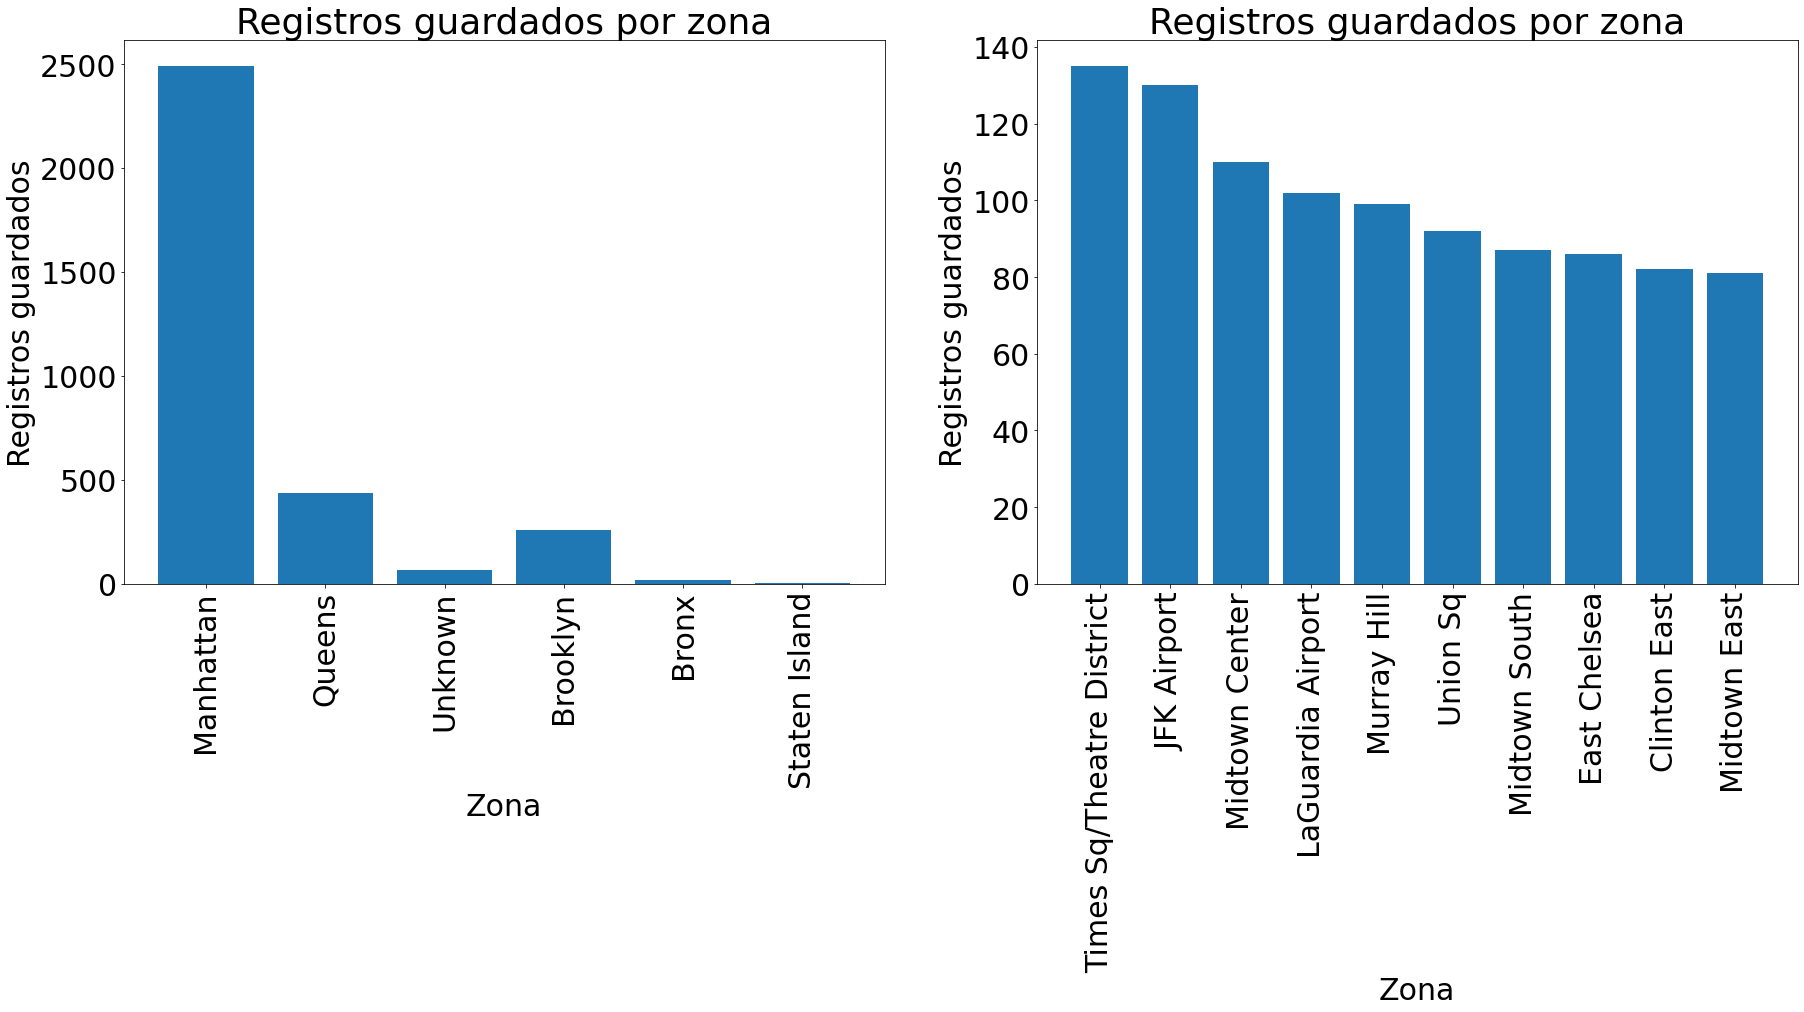

In [52]:
distritos = defaultdict(int)
zonas = defaultdict(int)

for i, loc_id in enumerate(zone_tuples.collect()):
    num = loc_id[1]
    loc_id = str(loc_id[0])
    zona = zone_lookup[loc_id]
    
    distritos[zona['distrito']] += num
    zonas[zona['zona']] = num

distritos_x = [k for k in distritos.keys()]
distritos_y = [v for v in distritos.values()]
zonas_x = [k for k in zonas.keys()]
zonas_y = [v for v in zonas.values()]


fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(1, 2, 1)
ax.bar(distritos_x, distritos_y)
ax.set_xlabel("Zona")
ax.set_ylabel("Registros guardados")
ax.set_title("Registros guardados por zona")
plt.xticks(rotation=90)

ax = fig.add_subplot(1, 2, 2)
ax.bar(zonas_x[:10], zonas_y[:10])
ax.set_xlabel("Zona")
ax.set_ylabel("Registros guardados")
ax.set_title("Registros guardados por zona")

plt.xticks(rotation=90)

plt.show()

# print(f"TOP {i+1} con {num}\n    Distrito: {zona['distrito']}\n    Zona: {zona['zona']}\n    Servicio: {zona['servicio']}")

### Viajes más comunes

# Fin

In [12]:
spark.stop()

IDEAS

propinas / hora

Timos

- Vueltas de mas en misma zona
- Tolls valores raros
- Diferencias exageradas de distancias para pares de datos con mismo origen y destino

Velocidad media de los taxis en función de la hora.

Viajes en taxi más comunes

Registros financieros (propinas, personas, etc.)

Zonas sin cobertura a partir del parámetro Store_and_fwd_flag
